In [1]:
# %conda install ffmpeg

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.earth.util import raan_from_ltan

import satastro

## Target trajectory

Here you choose which target to consider.

In [2]:
# Apophis asteroid flyby (11/04/2029-17/04/2029)
# Trajectory acquired from NASA/JPL Horizons service

from target.apophis import apophis_teme, apophis_mag
target_teme = apophis_teme
target_mag = apophis_mag['APmag']
target_mean_radec = SkyCoord(apophis_mag['R.A._(ICRF)'], apophis_mag['DEC_(ICRF)'], unit=u.deg, frame='icrs')
target_name = "Apophis"

In [2]:
# Secondary target : Gudrun asteroid (20/03/2029-23/03/2029)
# Trajectory acquired from NASA/JPL Horizons service

from target.gudrun import asteroid_teme, asteroid_mag
target_teme = asteroid_teme
target_mag = asteroid_mag['APmag']
target_mean_radec = SkyCoord(asteroid_mag['R.A._(ICRF)'], asteroid_mag['DEC_(ICRF)'], unit=u.deg, frame='icrs')
target_name = "Gudrun"

In [4]:
# GEO satellite
# Inclination and RAAN can be modified for GTO satellite

from target.geo_sat import sat_geo_teme
geo_teme = sat_geo_teme(i=0*u.deg, RAAN=90*u.deg)
target_teme = geo_teme
target_name = "GEO"

We plot the ground trace of the target.

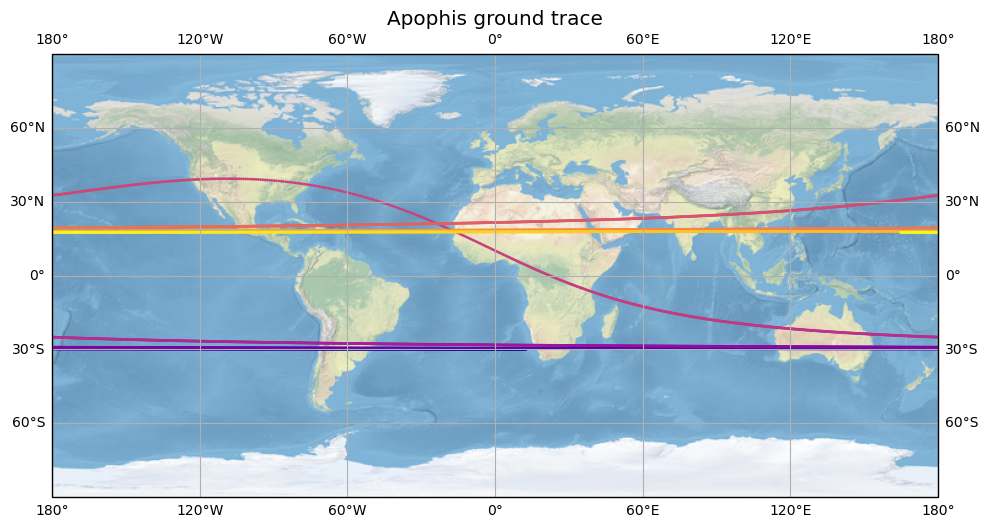

In [3]:
fig, ax = satastro.plot_world(color=True)
satastro.plot_trace(target_teme, ax)
ax.set_title(f"{target_name} ground trace")

fig.tight_layout()
plt.show()

We make a 3D plot to view the trajectory of the target.

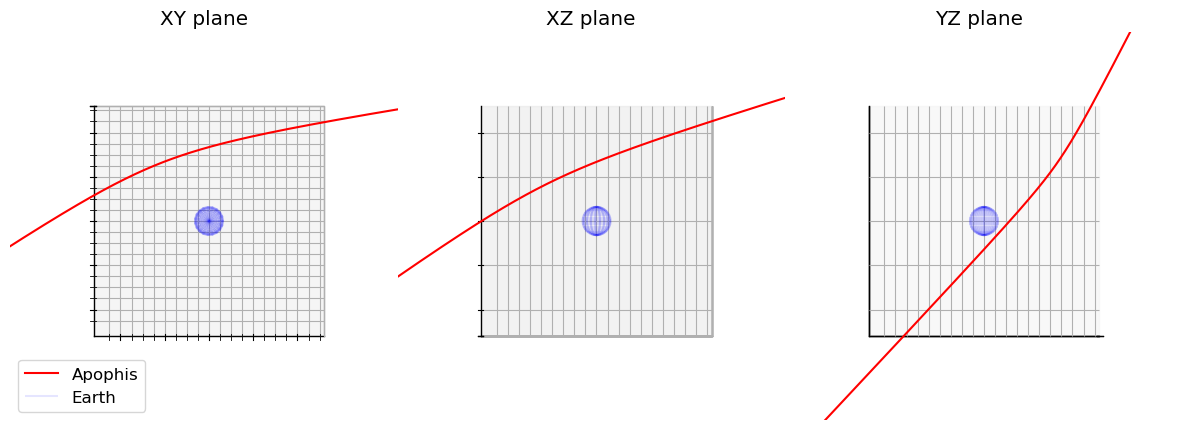

In [4]:
satastro.plot_3D_cartesian([{'cartesian':target_teme.cartesian, 'color':'r', 'label':target_name}], lim=5e4)

We can also look at the visibility of the target from a place on Earth (e.g. Polytechnique).

In [5]:
loc = EarthLocation(lat=48.7129508, lon=2.2116123, height=300) #Polytechnique

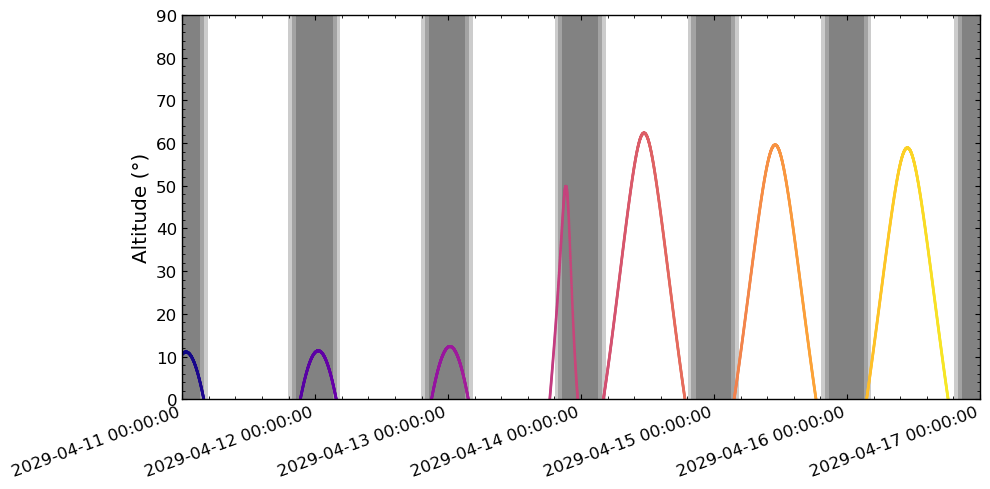

In [6]:
satastro.airmass_plot(target_teme, loc)

## Observer satellite

We define the observer satellite orbit using keplerian elements.

In [7]:
a = Earth.R + 500*u.km
e = 0.0*u.one
# i = 100*u.deg
# RAAN = 50*u.deg
RAAN = raan_from_ltan(epoch=target_teme.obstime[0], ltan=6.0*u.hourangle)
argp = 0.0*u.deg
nu = 0*u.deg

# sat = Orbit.from_classical(Earth, a=a, ecc=e, inc=i, raan=RAAN, argp=argp, nu=nu, epoch=target_teme.obstime[0])
sat = Orbit.heliosynchronous(Earth, a=a, ecc=e, raan=RAAN, argp=argp, nu=nu, epoch=target_teme.obstime[0])

We propagate the orbit to get the position of the observer satellite to match the target epochs.

In [8]:
sat_teme = satastro.orbit_to_TEME(sat, target_teme.obstime, perturbations=satastro.J2)

We plot the orbit of the observer satellite and the trajectory of the target.

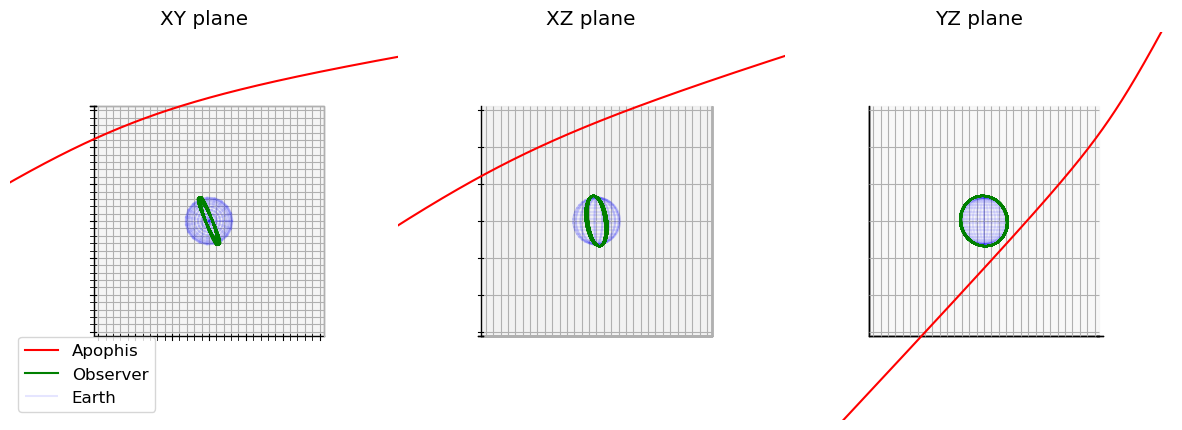

In [9]:
satastro.plot_3D_cartesian([{'cartesian':target_teme.cartesian, 'color':'r', 'label':target_name},
                            {'cartesian':sat_teme.cartesian, 'color':'g', 'label':'Observer'}], lim=3e4)

## Observation of the target from the satellite

We can first look at the distance between the satellite and the target, and the angle betwen the satellite-target vector and the normal vector to the orbital plane to know how fast and how much the satellite will have to rotate.

In [10]:
target_sat_vec = target_teme.cartesian.without_differentials()-sat_teme.cartesian.without_differentials()
dist = target_sat_vec.norm()

In [11]:
n_orbit = sat.h_vec.value
n_orbit_norm = n_orbit/np.linalg.norm(n_orbit)
orbital_angle = (np.arccos(np.sum(target_sat_vec.xyz.T.value*n_orbit_norm, axis=1)/dist.value)*u.rad).to(u.deg)

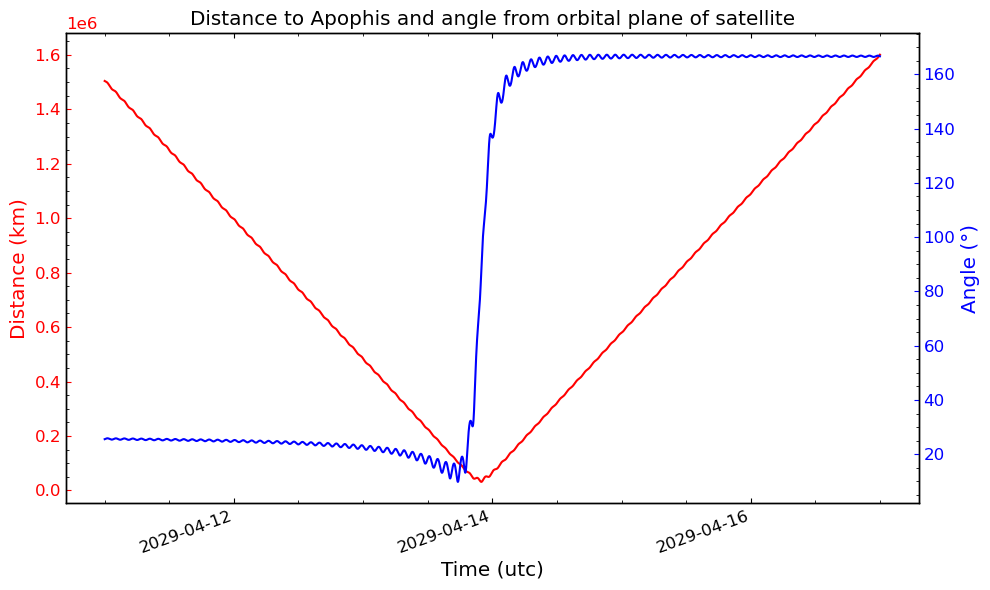

In [12]:
fig, ax1 = plt.subplots(figsize=(10,6))
dist_plot, = ax1.plot(target_teme.obstime, dist, c='r')
ax1.set_ylabel("Distance (km)", color=dist_plot.get_color())
ax1.tick_params(axis='y', colors=dist_plot.get_color())
ax2 = ax1.twinx()
ang_plot, = ax2.plot(target_teme.obstime, orbital_angle, c='b')
ax2.set_ylabel("Angle (°)", color=ang_plot.get_color())
ax2.tick_params(axis='y', colors=ang_plot.get_color())
# ax1.set_xlim(Time('2029-04-12T08:00:00.000', format='isot', scale='utc'), Time('2029-04-15T12:00:00.000', format='isot', scale='utc'))
fig.autofmt_xdate(rotation=20)
ax1.set_title(f"Distance to {target_name} and angle from orbital plane of satellite")
fig.tight_layout()
plt.show()

Then, we can plot the position in the sky of the target, as viewed by the satellite.

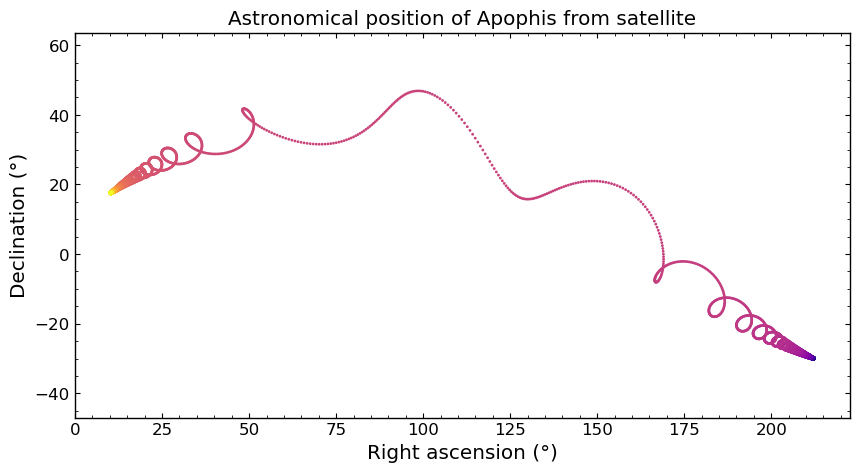

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
target_sat_radec, target_sat_color = satastro.astrometry_target_plot(target_teme, observer=sat_teme,
                                                                     target_name=target_name, 
                                                                     fig=fig, ax=ax, 
                                                                     return_radec=True, return_color=True)
plt.show()

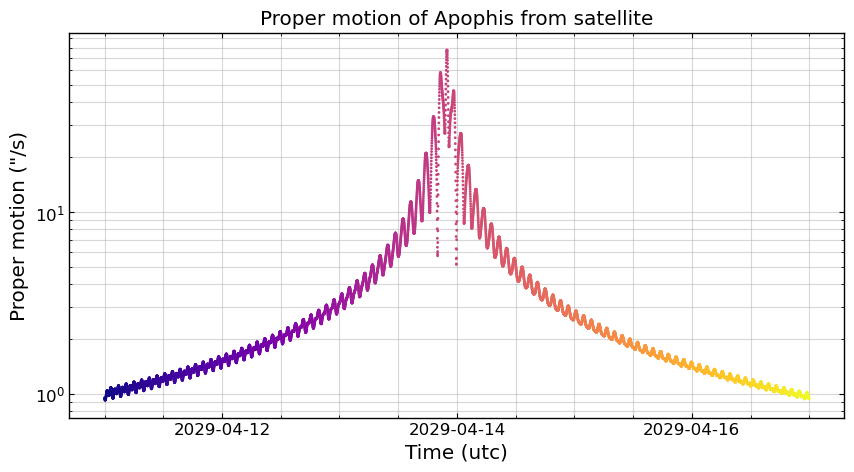

In [14]:
proper_motion = satastro.proper_motion(target_sat_radec, epoch=target_teme.obstime)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(target_teme.obstime[:-1], proper_motion, c=target_sat_color[:-1], s=1, zorder=2)
ax.set_ylabel('Proper motion ("/s)')
ax.set_yscale('log')
ax.grid(True, which='both', alpha=0.5)
ax.set_title(f"Proper motion of {target_name} from satellite")
plt.show()

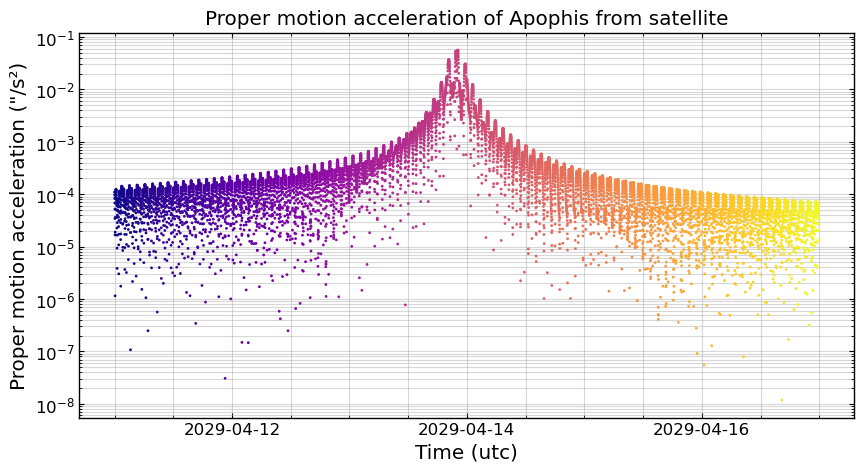

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
dt = (target_teme.obstime[1]-target_teme.obstime[0]).to_value(unit='s')*u.s
rot_accel = np.abs((proper_motion-np.roll(proper_motion,1)))[1:]/dt
ax.scatter(target_teme.obstime[:-2], rot_accel, c=target_sat_color[:-2], s=1, zorder=2)
ax.set_ylabel('Proper motion acceleration ("/s²)')
ax.set_yscale('log')
ax.grid(True, which='both', alpha=0.5)
ax.set_title(f"Proper motion acceleration of {target_name} from satellite")
plt.show()

A very important point is to know when the target will be blocked by the Earth and won't be visible by the satellite. The following plot shows the closest distance to Earth's center of the ray between the satellite and the target. When this distance is smaller than the Earth's radius, the target is in eclipse from the satellite. A simple atmopshere is also displayed to see when the light from the asteroid passes throught it.

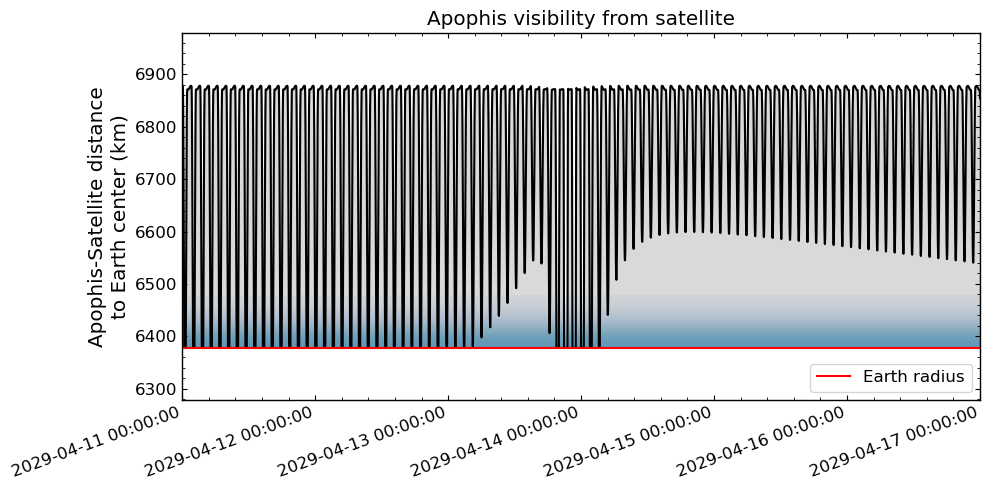

In [16]:
visibility = satastro.target_visibility_plot(sat_teme, target_teme, target_name=target_name, return_vis=True)
visibility_mask = visibility>(Earth.R+50*u.km)

Finally, we can simulate the astronomical positions of the target the observer satellite can see.

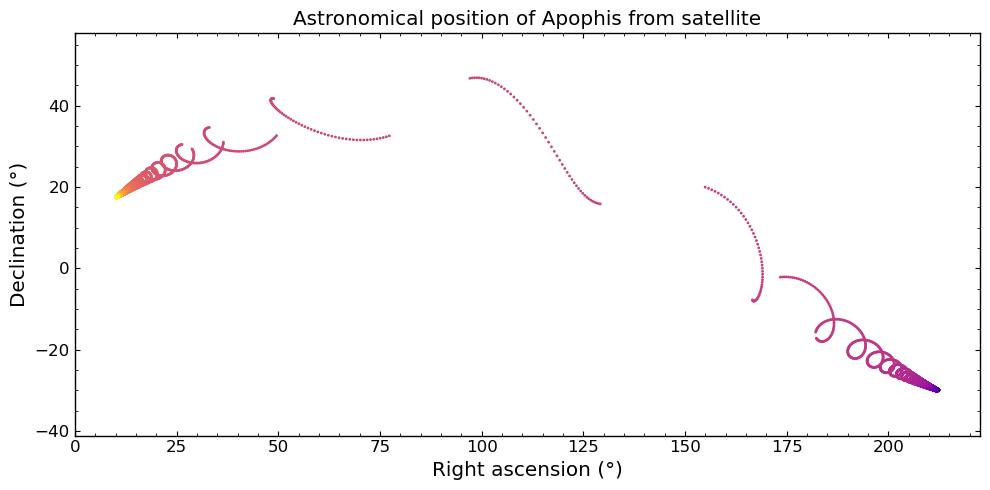

In [ ]:
satastro.astrometry_target_plot(target_teme, observer=sat_teme, target_name=target_name, mask=visibility_mask)

## Target magnitude

If we know the apparent magnitude of the target (for a target coming from NASA/JPL Horizons from example), we can look at its variation with time.

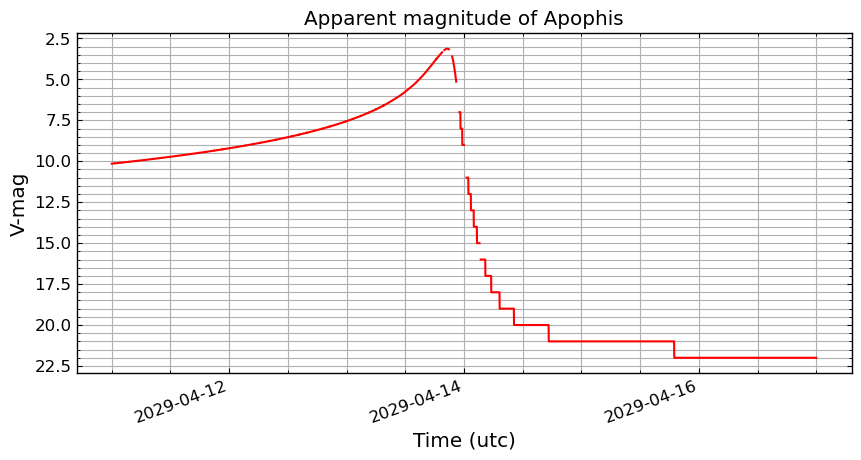

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
visible_mag = target_mag.copy()
visible_mag[np.logical_not(visibility_mask)] = np.inf
ax.plot(target_teme.obstime, visible_mag, c='r')
ax.invert_yaxis()
ax.set_ylabel(f"V-mag")
ax.set_title(f"Apparent magnitude of {target_name}")
ax.grid(axis='both', which='both')
fig.autofmt_xdate(rotation=20)
plt.show()

## Image simulation

Now that we know the magnitude of the tagert and where it is in the sky, viewed from the observer satellite, it's possible to simulate the images the satellite would take.

For that, we first define the Field-Of-View (FOV) of the observer satellite's camera, and the maximum magnitude of the stars (and target) we want to plot.

In [19]:
field_fov = (2.0*u.deg, 2.0*u.deg)
limiting_mag = 14.0

Then we define the pointings of the observer satellite, which can be chosen from multiple basic modes.

* Target-lock : Always looking at the target

In [24]:
# Target-lock
centers = target_sat_radec

* Mean-motion : Always looking at the mean motion of the target (position without parallax)

In [25]:
# # Mean-motion
# centers = target_mean_radec

* Mix : Switching between *target-lock* and *mean-motion* when the movement due to the parallax would make the target leave the FOV. To know when to switch, we define two distance thresholds (`far_threshold` and `too_far_threshold`) and we find the minimal angular separation between the *target-lock* and the *mean_motion* pointings when the distance is between the two thresholds. This ensures that the target will never leave the FOV before the mode switch, and finds the minimal re-pointing movement to make the switch.

In [26]:
# # Mix
# centers = target_mean_radec.copy()

# sep = target_mean_radec.separation(target_sat_radec)

# far_threshold = 0.3*min(field_fov)
# too_far_threshold = 0.4*min(field_fov)

# first_far = np.where(sep>far_threshold)[0][0]
# first_too_far = np.where(sep>too_far_threshold)[0][0]
# first_switch_focus = first_far+np.argmin(sep[first_far:first_too_far])

# last_far = np.where(sep>far_threshold)[0][-1]
# last_too_far = np.where(sep>too_far_threshold)[0][-1]
# last_switch_focus = last_far-np.argmin(sep[last_far:last_too_far:-1])

# centers[first_switch_focus:last_switch_focus] = target_sat_radec[first_switch_focus:last_switch_focus]

# fig, ax = plt.subplots(figsize=(10,5))
# ax.axhline(far_threshold.value, c='k', ls=':')
# ax.axhline(too_far_threshold.value, c='k', ls=':')
# ax.axvline(first_far, c='b', ls=':')
# ax.axvline(first_too_far, c='b', ls=':')
# ax.axvline(first_switch_focus, c='b')
# ax.axvline(last_far, c='g', ls=':')
# ax.axvline(last_too_far, c='g', ls=':')
# ax.axvline(last_switch_focus, c='g')
# ax.plot(np.arange(len(target_mean_radec)), sep, c='r')
# plt.show()

We plot the simulated image at maximum magnitude to check if it looks good.

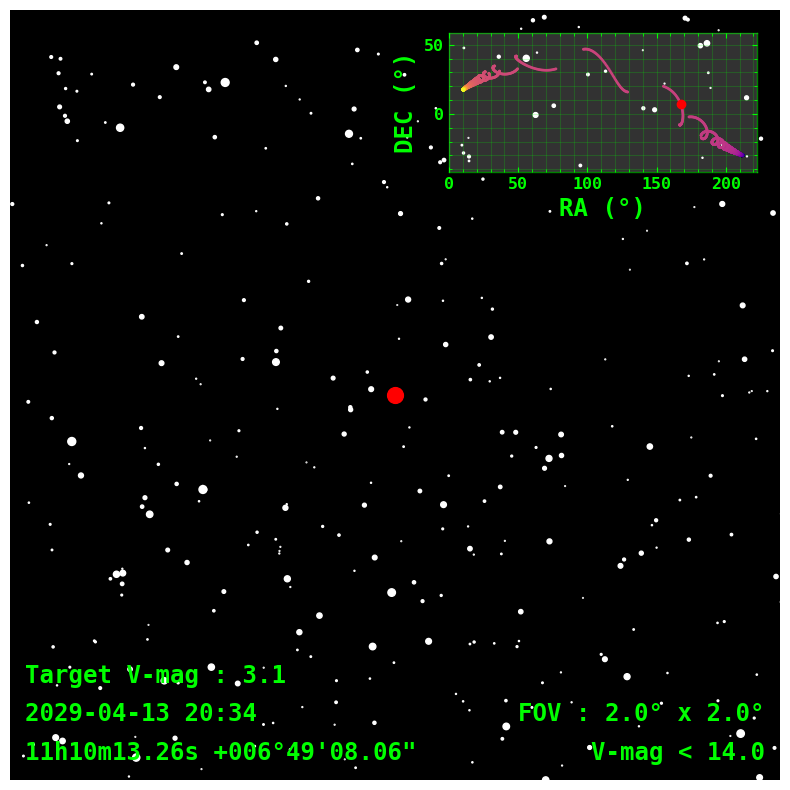

In [27]:
idx = np.argmin(visible_mag)
satastro.simulate_image(centers[idx], target_radec=target_sat_radec[idx],
                        field_fov=field_fov, limiting_mag=limiting_mag, 
                        epoch=target_teme.obstime[idx],
                        target_mag=target_mag[idx],
                        visibility=visibility_mask[idx], invert=False,
                        center_list=centers, visibility_list=visibility_mask, color_list=target_sat_color)
plt.show()

Now we can simulate all the images and save them.

In [ ]:
img_savedir = "image_sim"
satastro.batch_simulate_image(centers, step=10, start=0, save_dir=img_savedir,
                              target_radec_list=target_sat_radec,
                              epoch_list=target_teme.obstime,
                              field_fov=field_fov, limiting_mag=limiting_mag,
                              target_mag_list=target_mag, invert=False,
                              visibility_list=visibility_mask, color_list=target_sat_color)

100%|██████████| 52/52 [00:43<00:00,  1.20it/s]


Then, we can make a movie from the individual frames

In [ ]:
video_savedir = "."
satastro.make_video(image_dir=img_savedir, image_name="image-*.png",
                    save_dir=video_savedir, save_name="sim_video", 
                    FPS=20)

100%|██████████| 865/865 [00:53<00:00, 16.22it/s]


And finally we compress the movie to make it take less space and be eaiser to share.

In [ ]:
satastro.compress_video(f"{video_savedir}/sim_video.mp4", f"{video_savedir}/sim_video_compressed.mp4", 10.0, delete_in=True)